# Aircraft Engine Failure Classification

The problem is described [here](https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2)

**The dataset consist of three types of files:**
1. train_FD001.txt : run-to-failure data of similar type of 100 aircraft engine.
2. test_FD001.txt  : It is the operating data of 100 aircraft engine without failure events recorded.
3. RUL_FD001.txt   : true remaining cycles for each engine in the testing data. 



Data for 3 different setting and 21 sensors is given in train and test set

The Dataset can be obtained from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)

In [2]:
pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.metrics import recall_score
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

2024-11-10 00:09:05.287989: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 00:09:05.674232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 00:09:05.795944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 00:09:05.828975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 00:09:06.136250: I tensorflow/core/platform/cpu_feature_guar

**Problem Statement:**

We will solve a problem of classification where we will predict whether the engine will fail in next 30 cycles or not

In [4]:
# Data Source https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

In [5]:
#df is for train data. dfTest is for test data
df = pd.read_csv('CMAPSSData/train_FD001.txt', sep=" ", header=None)
df.columns=["unit_id",	"cycles",	"set1",	"set2",	"set3",	"s1",	"s2",	"s3"	,"s4"	,"s5"	,"s6"	,"s7"	,"s8"	,"s9"	,"s10"	,"se11"	,"s12"	,"s13"	,"s14"	,"s15",	"s16"	,"s17",	"s18"	,"s19",	"s20"	,"s21","s22","s23"]
dfTest = pd.read_csv('CMAPSSData/test_FD001.txt', sep=" ", header=None)
dfTest.columns=["unit_id",	"cycles",	"set1",	"set2",	"set3",	"s1",	"s2",	"s3"	,"s4"	,"s5"	,"s6"	,"s7"	,"s8"	,"s9"	,"s10"	,"se11"	,"s12"	,"s13"	,"s14"	,"s15",	"s16"	,"s17",	"s18"	,"s19",	"s20"	,"s21","s22","s23"]

In [6]:
df.head()

,unit_id,cycles,set1,set2,set3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,se11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [7]:
dfTest.head()

,unit_id,cycles,set1,set2,set3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,se11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


**Feature Information:**
1. unit_id has values from 1 to hundred. These values correspond to 100 engines
2. Number of cycles over of engine is given by 'cycles'
3. The last cycle for a unit_id is where that engine failed
4. set1,set2,set3 are three different setting of engines
5. s1 to s23 are sensor data of 23 sensors

In [8]:
# sort the dataframe such that engines and their number of cycles are in ascending order
df=df.sort_values(['unit_id', 'cycles'], ascending = [True, True])
dfTest=dfTest.sort_values(['unit_id', 'cycles'], ascending = [True, True])

In [9]:
# Read data of Remaining useful life(RUL) of engines in test set
dfRUL=pd.read_csv('CMAPSSData/RUL_FD001.txt', header=None)
dfRUL.columns=["RULmax"]
# associate it with id of engines
dfRUL['unit_id']=np.arange(1,len(dfRUL)+1)
dfRUL.head()

,RULmax,unit_id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [10]:
#merge two dataframe such that we have info of max RUL for each record
#subtract number of cycles from each record from RULmax to get RUL
dfTest=pd.merge(dfTest, dfRUL, on='unit_id')
dfTest['RUL']=(dfTest.groupby(['unit_id'])['cycles'].transform(max)+dfTest['RULmax'])-dfTest['cycles']

/tmp/ipykernel_216270/2554263908.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  dfTest['RUL']=(dfTest.groupby(['unit_id'])['cycles'].transform(max)+dfTest['RULmax'])-dfTest['cycles']


In [11]:
dfTest

,unit_id,cycles,set1,set2,set3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,se11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23,RULmax,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,112,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,112,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,112,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,112,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,112,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN,20,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN,20,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN,20,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN,20,21


In [12]:
# sensors s22 and s23 has no data so drop them
df=df.drop(['s22','s23'],axis=1)
dfTest=dfTest.drop(['s22','s23'],axis=1)

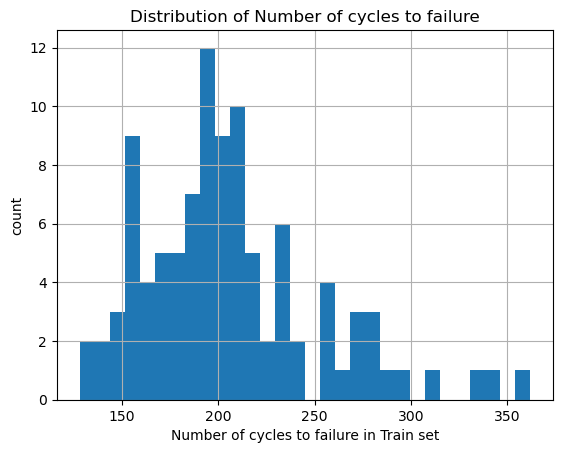

In [13]:
df['unit_id'].value_counts().hist(bins=30)
plt.title('Distribution of Number of cycles to failure')
plt.ylabel('count')
plt.xlabel('Number of cycles to failure in Train set');
plt.show()

**Observations:**
1. The distribution is somewhat bell shaped
2. around 12 engines failed after 200 cycles, which is maximum in distribution
3. Very few engines failed after 300 cycles

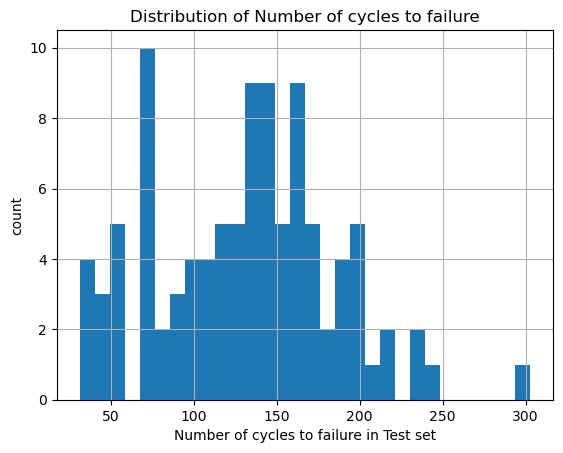

In [14]:
dfTest['unit_id'].value_counts().hist(bins=30)
plt.title('Distribution of Number of cycles to failure')
plt.ylabel('count')
plt.xlabel('Number of cycles to failure in Test set');
plt.show()

In [15]:
#https://stackoverflow.com/questions/15138973/how-to-get-the-number-of-the-most-frequent-value-in-a-column/30063996
#df['unit_id'].value_counts().sort_index()
print("Max count in Train set")
print("id=",df['unit_id'].value_counts().idxmax())
print("value=",df['unit_id'].value_counts().max())
print("\n\nMin count in Train set")
print("id=",df['unit_id'].value_counts().idxmin())
print("value=",df['unit_id'].value_counts().min())

Max count in Train set
id= 69
value= 362


Min count in Train set
id= 39
value= 128


In [16]:
#df['unit_id'].value_counts().sort_index()
print("Max count in Test set")
print("id=",dfTest['unit_id'].value_counts().idxmax())
print("value=",dfTest['unit_id'].value_counts().max())
print("\n\nMin count in Test set")
print("id=",dfTest['unit_id'].value_counts().idxmin())
print("value=",dfTest['unit_id'].value_counts().min())

Max count in Test set
id= 49
value= 303


Min count in Test set
id= 1
value= 31


**Observations:**
1. In train set engine with id=69 took maximum number of cycles to fail i.e. 362 cycles
2. In train set engine with id=39 took minimum number of cycles to fail i.e. 128 cycles
3. In test set engine with id=49 took maximum number of cycles to fail i.e. 303 cycles
4. In test set engine with id=1 took minimum number of cycles to fail i.e. 31 cycles


In [17]:
# Engines in test set that has less than 70 records in test set
testCount=dfTest['unit_id'].value_counts().sort_values()
print(testCount[testCount <= 70])

unit_id
1     31
85    34
39    37
22    39
14    46
25    48
2     49
33    50
69    54
44    54
9     55
87    56
88    68
71    68
Name: count, dtype: int64


In [18]:
#1,85,39,22,14,25,2,33,69,44,9,87,71,88 has cycles less than 70. 
#so we remove those records because we will make a sequence of 70 as input to LSTM network
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 1)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 85)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 39)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 22)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 14)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 25)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 2)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 33)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 69)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 44)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 9)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 87)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 71)].index)
dfTest = dfTest.drop(dfTest[(dfTest['unit_id'] == 88)].index)

In [19]:
# subtract current number of cycles from maximum cycles for each id to get RUL 
df['RUL']=df.groupby(['unit_id'])['cycles'].transform(max)-df['cycles']
dfTest=dfTest.drop("RULmax",axis=1)

/tmp/ipykernel_216270/428559419.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['RUL']=df.groupby(['unit_id'])['cycles'].transform(max)-df['cycles']


In [20]:
# normalise data to get a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df.iloc[:,1:-1]=scaler.fit_transform(df.iloc[:,1:-1])
dfTest.iloc[:,1:-1]=scaler.fit_transform(dfTest.iloc[:,1:-1])

/tmp/ipykernel_216270/457496109.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.00277008 0.00554017 ... 0.54570637 0.54847645 0.55124654]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,1:-1]=scaler.fit_transform(df.iloc[:,1:-1])
/tmp/ipykernel_216270/457496109.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.33333333 0.16666667 ... 0.83333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,1:-1]=scaler.fit_transform(df.iloc[:,1:-1])
/tmp/ipykernel_216270/457496109.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.00331126 0.00662252 ... 0.64569536 0.64900662 0.65231788]' has dtype incompatible with

In [21]:
# Some record have zero std dev
df.describe()

,unit_id,cycles,set1,set2,set3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,se11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,0.298637,0.499490,0.501959,0.0,0.0,0.443052,0.424746,0.450435,0.0,0.980321,0.566459,0.297957,0.195248,0.0,0.411410,0.580697,0.317871,0.226095,0.451118,0.0,0.434221,0.0,0.0,0.524241,0.546127,107.807862
std,29.227633,0.190806,0.125708,0.244218,0.0,0.0,0.150618,0.133664,0.151935,0.0,0.138898,0.142527,0.107554,0.099089,0.0,0.158981,0.157261,0.105763,0.098442,0.144306,0.0,0.129064,0.0,0.0,0.140114,0.149476,68.880990
min,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,26.000000,0.141274,0.413793,0.333333,0.0,0.0,0.335843,0.331807,0.339467,0.0,1.000000,0.476651,0.227273,0.140761,0.0,0.297619,0.484009,0.235294,0.171870,0.346287,0.0,0.333333,0.0,0.0,0.434109,0.452361,51.000000
50%,52.000000,0.285319,0.500000,0.500000,0.0,0.0,0.430723,0.415522,0.435348,0.0,1.000000,0.578100,0.287879,0.174684,0.0,0.392857,0.594883,0.308824,0.209516,0.438630,0.0,0.416667,0.0,0.0,0.534884,0.557443,103.000000
75%,77.000000,0.429363,0.586207,0.750000,0.0,0.0,0.539157,0.508829,0.545324,0.0,1.000000,0.669887,0.363636,0.213991,0.0,0.505952,0.695096,0.382353,0.249613,0.541362,0.0,0.500000,0.0,0.0,0.627907,0.652582,155.000000
max,100.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,361.000000


In [22]:
# Some record have zero std dev
dfTest.describe()

,unit_id,cycles,set1,set2,set3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,se11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
count,12407.000000,12407.000000,12407.000000,12407.000000,12407.0,12407.0,12407.000000,12407.000000,12407.000000,12407.0,12407.000000,12407.000000,12407.000000,12407.000000,12407.0,12407.000000,12407.000000,12407.000000,12407.000000,12407.000000,12407.0,12407.000000,12407.0,12407.0,12407.000000,12407.000000,12407.000000
mean,51.900056,0.260405,0.511903,0.464204,0.0,0.0,0.424370,0.494954,0.415337,0.0,0.969292,0.580854,0.439463,0.254172,0.0,0.421855,0.541184,0.419124,0.275041,0.445757,0.0,0.446572,0.0,0.0,0.529699,0.566556,141.235029
std,28.076334,0.175446,0.137669,0.226549,0.0,0.0,0.127192,0.130529,0.137789,0.0,0.172534,0.138554,0.140606,0.088720,0.0,0.135672,0.129142,0.133049,0.090743,0.140252,0.0,0.155223,0.0,0.0,0.129782,0.119829,60.418108
min,3.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,7.000000
25%,29.000000,0.119205,0.418750,0.307692,0.0,0.0,0.334385,0.403532,0.316929,0.0,1.000000,0.491935,0.341463,0.196963,0.0,0.321918,0.456621,0.325581,0.216557,0.348035,0.0,0.375000,0.0,0.0,0.445455,0.489384,99.000000
50%,52.000000,0.238411,0.512500,0.461538,0.0,0.0,0.419558,0.492080,0.408413,0.0,1.000000,0.588710,0.439024,0.245312,0.0,0.417808,0.550228,0.418605,0.269512,0.440556,0.0,0.500000,0.0,0.0,0.536364,0.571975,141.000000
75%,76.000000,0.377483,0.606250,0.692308,0.0,0.0,0.507886,0.580369,0.503778,0.0,1.000000,0.679435,0.536585,0.297691,0.0,0.506849,0.632420,0.511628,0.322468,0.534995,0.0,0.500000,0.0,0.0,0.618182,0.649115,181.000000
max,100.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,340.000000


In [23]:
# Remove record with zero standard deviation
#https://stackoverflow.com/questions/39658574/how-to-drop-columns-which-have-same-values-in-all-rows-via-pandas-or-spark-dataf
df=df.drop(df.std()[(df.std() == 0)].index, axis=1)
dfTest=dfTest.drop(dfTest.std()[(dfTest.std() == 0)].index, axis=1)

In [24]:
df.shape

(20631, 20)

In [25]:
dfTest.shape

(12407, 20)

Note : Seven features are dropped

Text(0.5, 0, 'All settings and sensors over time in Train Set for Engine ID=1')

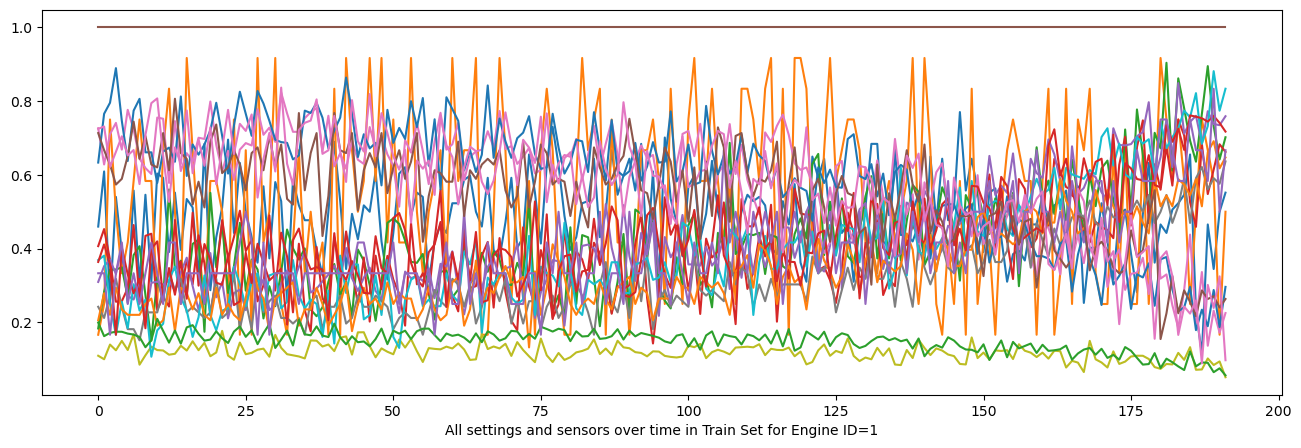

In [26]:
ax = df.loc[(df.unit_id == 1)].iloc[:,2:-1].plot(figsize=(16, 5),legend=None)
ax.set_xlabel("All settings and sensors over time in Train Set for Engine ID=1")

Text(0.5, 0, 'All settings and sensors over time in Train Set for Engine ID=19')

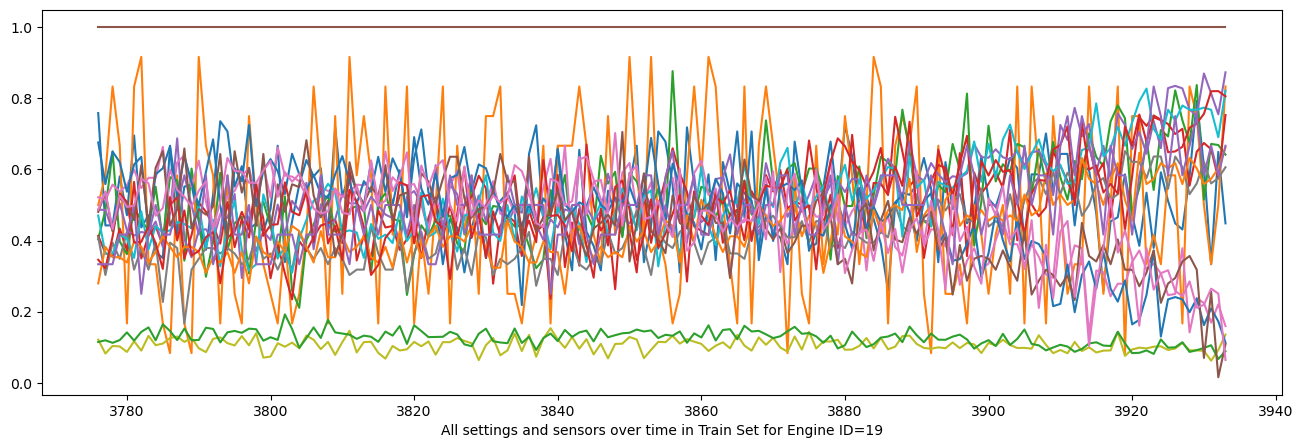

In [27]:
ax = df.loc[(df.unit_id == 19)].iloc[:,2:-1].plot(figsize=(16, 5),legend=None)
ax.set_xlabel("All settings and sensors over time in Train Set for Engine ID=19")

Text(0.5, 0, 'All settings and sensors over time in Train Set  for Engine ID=99')

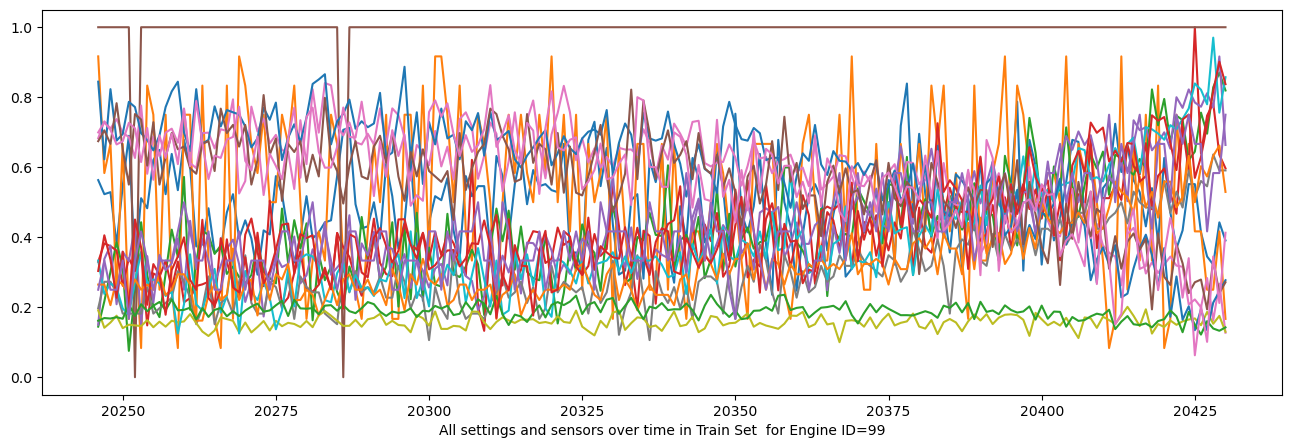

In [28]:
ax = df.loc[(df.unit_id == 99)].iloc[:,2:-1].plot(figsize=(16, 5),legend=None)
ax.set_xlabel("All settings and sensors over time in Train Set  for Engine ID=99")

**Observations:**
1. This is a plot of all settings and sensors in one figure 
2. As the engine gets closer to failure the waveforms gets closer to each other and overlap
3. Then they get spread again before failure

In [29]:
dfRUL.loc[dfRUL['unit_id']==100]

,RULmax,unit_id
99,20,100


Text(0.5, 0, 'All settings and sensors over time in Test Set for Engine ID=100 with RUL=20')

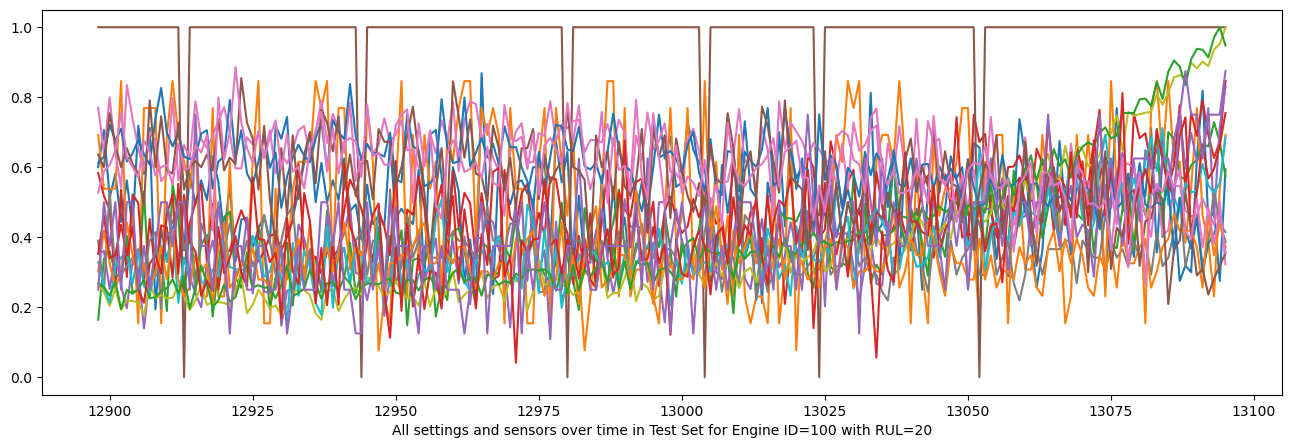

In [30]:
ax = dfTest.loc[(dfTest.unit_id == 100)].iloc[:,2:-1].plot(figsize=(16, 5),legend=None)
ax.set_xlabel("All settings and sensors over time in Test Set for Engine ID=100 with RUL=20")

**Observations:**
1. Only 20 cycles are remaining before failure 
2. Hence waveforms get closer to each other and overlap

In [31]:
dfRUL.loc[dfRUL['unit_id']==96]

,RULmax,unit_id
95,137,96


Text(0.5, 0, 'All settings and sensors over time in Test Set for Engine ID=96 with RUL=137')

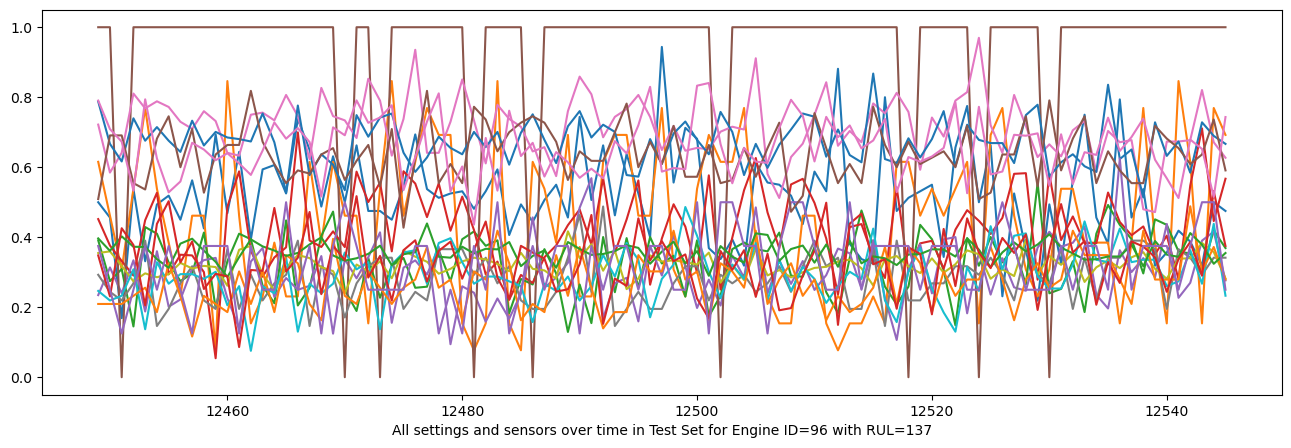

In [32]:
ax = dfTest.loc[(dfTest.unit_id == 96)].iloc[:,2:-1].plot(figsize=(16, 5),legend=None)
ax.set_xlabel("All settings and sensors over time in Test Set for Engine ID=96 with RUL=137")

**Observations:**
1. The waveforms are 137 cycles away from failure. Thats far away.
2. Hence waveforms do not get closer to each other and overlap
3. The frequency(number of variations in given time) of waveforms is also less when they are away from failures

In [33]:
# Creating class labels
# 1 when engine is going to fail within next 30 cycles. 0 otherwise
df['label30']=np.where(df['RUL']<30,1,0)
dfTest['label30']=np.where(dfTest['RUL']<30,1,0)

In [34]:
# 70 timesteps (cycles) to produce one sequence
batch70=70
trainIDs=list(df['unit_id'].unique())
inputNP = np.empty((0,18), int)
labelList=[]

In [ ]:
# Create 3D array from training set for input to LSTM
for id in trainIDs:
    dfTemp=df.loc[df['unit_id']==id]
    start=0
    for i in  range(len(dfTemp)-batch70+1):
        inputNP = np.append(inputNP, dfTemp.iloc[start:start+batch70,1:-2], axis=0)
        labelList.append(dfTemp['label30'].iloc[start+batch70-1])
        start=start+1
trainLSTM = np.reshape(inputNP, (-1,70, 18)) 
trainLSTM=trainLSTM.astype('float32')
trainLSTM.shape

In [ ]:
# Array for training labels
trainLabel=np.array(labelList)
trainLabel=np.reshape(trainLabel, (-1,1))
trainLabel.shape

In [ ]:
# Create 3D array from testing set for evaluation
testIDs=list(dfTest['unit_id'].unique())
inputNP = np.empty((0,18), int)
labelList=[]

for id in testIDs:
    dfTemp=dfTest.loc[dfTest['unit_id']==id]
    start=0
    for i in  range(len(dfTemp)-batch70+1):
        inputNP = np.append(inputNP, dfTemp.iloc[start:start+batch70,1:-2], axis=0)
        labelList.append(dfTemp['label30'].iloc[start+batch70-1])
        start=start+1
testLSTM = np.reshape(inputNP, (-1,70, 18)) 
testLSTM=testLSTM.astype('float32')
testLSTM.shape

In [ ]:
# Array for testing labels
testLabel=np.array(labelList)
testLabel=np.reshape(testLabel, (-1,1))
testLabel.shape

In [ ]:
#Modeling
from tensorflow.keras import regularizers
batch70=70
opt = keras.optimizers.Adam(learning_rate=0.004)
model = Sequential()
model.add(LSTM(input_shape=(batch70, trainLSTM.shape[2]),units=100,return_sequences=True,activity_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(LSTM(units=50,return_sequences=False,activity_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(units=trainLabel.shape[1], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.Recall()])
print(model.summary())

In [ ]:
resultTrain=model.fit(trainLSTM, trainLabel, epochs=200, batch_size=256, validation_split=0.25, verbose=1, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')])

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(resultTrain.history["loss"], label="training loss")
plt.plot(resultTrain.history["val_loss"], label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();



In [ ]:
#Evaluate
resultTest = model.evaluate(testLSTM, testLabel)

In [ ]:
print('Recall =',resultTest[1])

In [ ]:
def recommend_failure(unit_id, RUL_MAX, df, model, scaler):
    df_engine = df[df['unit_id'] == unit_id].copy() 
    if df_engine.empty:
        return f"No data found for engine ID {unit_id}."
    last_cycles = df_engine.tail(70)
    if len(last_cycles) < 70:
        padding = pd.DataFrame(
            np.zeros((70 - len(last_cycles), last_cycles.shape[1])),
            columns=last_cycles.columns
        )
        last_cycles = pd.concat([padding, last_cycles], ignore_index=True)
    max_cycles = last_cycles['cycles'].max()
    last_cycles['RUL'] = (max_cycles + RUL_MAX) - last_cycles['cycles']
    columns_to_drop = ['s22', 's23']
    last_cycles.drop([col for col in columns_to_drop if col in last_cycles.columns], axis=1, inplace=True)
    #last_cycles.iloc[:, 1:-1] = scaler.transform(last_cycles.iloc[:, 1:-1])
    num_features = last_cycles.shape[1] - 3  
    if num_features < 18:
        for i in range(18 - num_features):
            last_cycles[f'pad_feature_{i}'] = 0
    elif num_features > 18:
        drop_count = num_features - 18
        last_cycles = last_cycles.iloc[:, :-drop_count]
    last_cycles['label30'] = np.where(last_cycles['RUL'] < 30, 1, 0)
    inputNP = last_cycles.iloc[:, 1:-2].values  
    inputNP = inputNP.reshape(1, 70, 18) 
    print(f"testLSTM shape: {inputNP.shape}")
    testLabel = np.array([last_cycles['label30'].iloc[-1]]).reshape(1, 1)
    resultTest = model.evaluate(inputNP, testLabel)
    if resultTest[0] < 0.5:  
        return f"Engine ID {unit_id} is predicted to fail within the next 30 cycles."
    else:
        return f"Engine ID {unit_id} is not predicted to fail within the next 30 cycles."

unit_id = 1 
RUL_MAX = 200  
recommendation = recommend_failure(unit_id, RUL_MAX, df, model, scaler)
print(recommendation)

In [ ]:
# Save the model to an H5 file
model.save('engine_failure_model.h5')
